## SCRIMP: Partitioned Finite Element Method (PFEM) for port-Hamiltonian systems with boundary damping: anisotropic heterogeneous wave equation

<b>Goal</b>: This <a href="https://jupyter.org"> Jupyter</a> notebook aims at illustrating the use of the Partitioned Finite Element Method (PFEM) to discretize a port-Hamiltonian system related to the two-dimensional wave equation. We specifically learn how to define the problem inside SCRIMP. This notebook is related to the companion paper "Partitioned Finite Element Method for port-Hamiltonian systems with boundary damping: anisotropic heterogeneous 2D wave equation" by A. Serhani, D. Matignon and G. Haine, (2019).

<b>Note</b>: a cell is made active by first clicking on the left part of the web page (a blue vertical line appears) and then pushing Shift+Enter. 

<b>Note</b>: The next cell has to be activated only once and specifies the Python libraries we will use in this notebook. A basic knowledge of Python is only expected to understand the code used in the cells.  

In [1]:
#
# To allow plots within the Notebook 
#
%matplotlib inline

# Import here the standard Python libraries used in the Notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, show_config
import sys 
import time
import dolfin as df

# Import here the classes related to SCRIMP
from Wave import Wave_2D
from model_reduction import Model_Reduction
#from fbpca import pca
#from util  import cholesky_qr


Could not find GLIMDA.


### Python version

In [2]:
print(sys.version)

3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 15:43:19) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### <a href="https://fenicsproject.org">FEniCS</a> version 

In [3]:
print(df.__version__)

2019.1.0


### <a href="https://fenicsproject.org">Scipy</a> Linear algebra libraries

In [4]:
print(show_config())

mkl_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
system_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
None


# A. Anisotropic heterogeneous 2D wave equation:


We consider the two-dimensional heterogeneous anisotropic wave equation defined for all $t\ge 0$ as
$$
\begin{array}{ll} 
    \rho(\boldsymbol x)\,\displaystyle \frac{\partial^2}{\partial t^2} w(t,\boldsymbol x) &=& \text{div}\Big(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)\Big), \quad \boldsymbol x \in \Omega, \\
    Z(\boldsymbol x)~(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)) \cdot {\bf{n}} + 
    {\partial_t} w(t,\boldsymbol x) & = & 0, \quad \boldsymbol x \in \partial \Omega, \\ 
    w(0, \boldsymbol x) & = & w_0(x), \quad \boldsymbol x \in \Omega, t=0 \\
    {\partial_t} w(0,\boldsymbol x) & = & w_1(x), \quad \boldsymbol x \in \Omega, t=0, \\
\end{array}
$$
with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega$. 

$w(t,\boldsymbol x)$ denotes the deflection from the equilibrium position at point $\boldsymbol x \in \Omega $ and time $t$. $\rho \in L^{\infty}(\Omega)$ (positive and bounded from below) denotes the mass density, $\overline{\overline T} \in L^{\infty}(\Omega)^{2\times 2}$ (symmetric and coercive) the Young's elasticity modulus, $Z(\boldsymbol x)$ is the positive impedance function defined on $\partial \Omega$. 


<b>Structure of part A</b>: This notebook first defines the continuous problem by using a specific class of SCRIMP related to the wave equation in two dimensions. Then we tackle the discretization in space of the port-Hamiltonian system through the PFEM methodology. This discretization leads to a ODE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

### Class object related to the PDE wave equation

In [5]:
W = Wave_2D()

### Constants and parameters 

In [6]:
#
# Define constants related to the definition of the geometric rectangular domain
#
x0, xL, y0, yL = 0., 2., 0., 1.
#
# Define constants related to the time discretization [tclose corresponds to the time when we decide to consider 
# the system as a closed system]
#
tinit  = 0.
tfinal = 5.
tclose = 1.
#
# Define the parameters related to the time discretization [only required for the Crank-Nicolson scheme]
# 
dt     = 5.e-2
theta  = 0.5
#
# Specify the method to be used for the time integration
#
time_method = 'ODE:Assimulo'

### FEniCS expressions definition

In [7]:
#
# Define Fenics Expressions 
#

# Mass density (TBC: role of xL in this expression)
Rho    = 'x[0]*x[0] * (xL-x[0])+ 1'

# Young's elasticity modulus
T11    = 'x[0]*x[0]+1'
T12    = 'x[1]'
T22    = 'x[0]+1'

# Impedance function on the boundary
Z      = '0.1'
  
# Initial conditions related to the deflection and to the time derivative of the deflection   
W0     = '0' # Initial condition on the deflection
Ap_0   = '0' # Initial condition on the velocity (time derivative of the deflection)
Aq_0_1 = '0' # Initial condition on the strain (x-component)
Aq_0_2 = '0' # Initial condition on the strain (y-component)
    
# Boundary control function that controls the time derivative of the deflection on the whole boundary  
# Geometrical part as a FEniCS expression
boundary_cntrl_space = 'x[0] * ( sin(2*pi*x[1]) + 1)'

# Time part of the control defined as a pure Python function
def boundary_cntrl_time(t,close_time):
    """
    Specify here the time part of the boundary control as a pure Python function 
    """        
    if t <= close_time:
        return np.sin(2*np.pi*t)
    else:
        return 0.

### Problem at the continuous level

In [8]:
#
# Problem definition at the continous level
#
   
# Select the domain as a rectangular domain of shape [x0, xL] x [y0, yL]    
W.Set_rectangular_domain(x0, xL, y0, yL)
 
# Specify the physical parameters    
W.Set_physical_parameters(Rho, T11, T12, T22)
    
# Specify the impendance function 
W.Set_impedance(Z)
  
# Specify the initial conditions related to [TBC]
    
# Specify the boundary control function (space) 
W.Set_boundary_cntrl_space(boundary_cntrl_space)

# Specify the boundary control function (time)
# If nothing is specified, the control is only space dependent
# otherwise it corresponds to the product of the two space and time functions.
W.Set_boundary_cntrl_time(boundary_cntrl_time)

# Specify the initial, closing and final time
W.Set_initial_close_final_time(tinit,tclose,tfinal)
   
# Check    
assert W.Check_Problem_Definition() == 1, "Problem definition to be checked again !"

### Problem at the discrete level in space and time

In [ ]:
#
# Finite Element Space and Time discretization of the weak formulation
# 
  
# Generate the computational mesh with rfn as a refinement parameter on the whole boundary    
W.Generate_mesh(rfn=10)
    
# Select the FE approximation spaces of Raviart-Thomas type
W.Set_FE_Approximation_Spaces(family_q='RT', family_p='P', family_b='P',\
                              rt_order=0, p_order=1, b_order=1)
    
# Discretization in space of the weak formulation with PFEM    
W.Apply_PFEM_formulation(formulation='div')
  
# Interpolate the initial data on the appropriate FE spaces
W.Project_initial_data_FE_spaces(W0, Aq_0_1, Aq_0_2, Ap_0)
   
# Specify the parameters related to the time discretization
W.Set_time_setting(dt, theta, time_method)
 
# Check
assert W.Check_Space_Time_Discretization() == 1, "Space and time discretization to be checked again !"

### Numerical approximation of the space-time solution

In [ ]:
#
# Numerical Approximation of the space-time solution
#

Aq, Ap, Ham, Deflection, t_span = W.Time_integration(time_method)

# Check 


ODE Integration using assimulo built-in functions:
Final Run Statistics: --- 

 Number of steps                                 : 443
 Number of function evaluations                  : 829
 Number of Jacobian*vector evaluations           : 1189
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 2
 Number of nonlinear iterations                  : 825
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : SPGMR
 Maximal order            : 3
 Tolerances (absolute)    : 0.001
 Tolerances (relative)    : 0.001

Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 1.3614111170000003 seconds.


### Post-processing

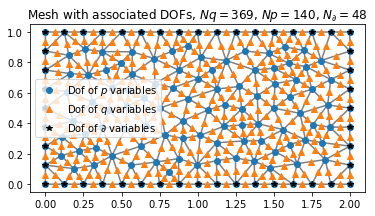

In [ ]:
# Specify the mode
W.notebook = True

# Plot of the mesh with corresponding DOFs
W.plot_mesh_with_DOFs()    

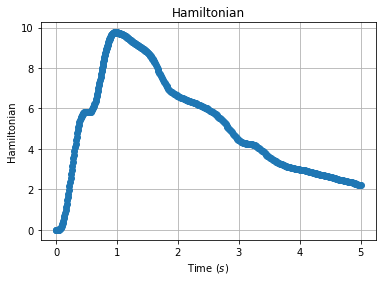

In [ ]:
# Plot of the Hamiltonian function versus time
W.plot_Hamiltonian(t_span,Ham, marker='o')

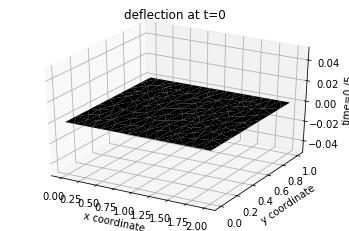

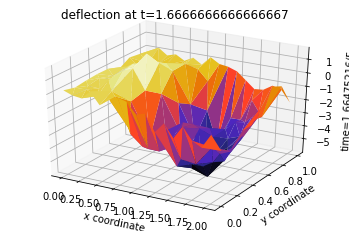

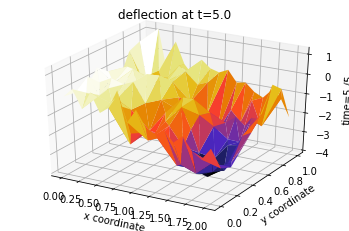

In [ ]:
# 3D Plot of the deflection at final time 
W.plot_3D(Deflection,0,'deflection at t='+str(0))
W.plot_3D(Deflection,tfinal/3,'deflection at t='+str(tfinal/3))
W.plot_3D(Deflection,tfinal,'deflection at t='+str(tfinal))

In [ ]:
# Movie shown in a new window 

movie = True

if movie:
    %matplotlib tk
    W.set_video_writer()
    W.moving_trisurf(Deflection,1,'Deflection_versus_time',save=True)
    %matplotlib inline

# B. Model reduction of the closed system

<b>Structure of part B</b>: We first perform the singular value analysis of the snapshot matrices corresponding to the closed system. Then we learn how to properly construct the reduced pHS model and then perform its time integration. Finally, we perform an eigenvalue analysis of the generalized eigenvalue problem.

##  Singular Value Decomposition of the snapshot matrices

In [ ]:
#
# Define the X and F snapshot matrices
# 

# Take the corresponding part related to the closed system
X = np.concatenate((Aq[:,W.Nclose:],Ap[:,W.Nclose:]))
F = W.Q @ X
M = W.M
     
#
# Check if data are correct and assign the dimensions of the matrix
#
assert X.shape[:] == F.shape[:]
m, n              = X.shape[:]  

# Set the parameters for the SVD analysis
# threshold is the relative threshold for the truncated SVD (0 < threshold < 1)
# approximate_rank is not used in the truncated SVD algorithm

threshold        = 1.e-6
approximate_rank = min(m,n)

#
# Define the model reduction object
#

MR = Model_Reduction(X,F)
    
# Specify the weight matrix to be used in the model reduction
    
MR.Specify_Weight_Matrix(M)

#
# Specify the method to be used: SVD corresponds to a truncated SVD
# with threshold as relative threshold on the singular value decay
#

MR.Specify_POD_Method('SVD')
      
# Call the reduction method on the MR object of SCRIMP

t_start = time.time()
assert MR.POD_Reduction(threshold,approximate_rank) == 1
print("Time spent in the analysis",time.time()-t_start)

print("Dimension of the global model",m)
print("Dimension of the reduced model",MR.r)

### Plots related to the singular value decay of the snapshot matrices

In [ ]:
#
# Create two subplots to show the singular value decay
#
    
fig, (ax1, ax2) = plt.subplots(2,sharey=True)

message = "Singular value decay - Matrix size (m,n)=("+str(m)+","+str(n)+")"
x  = np.arange(min(m,n)) + 1
ax1.semilogy(x, (MR.xs[:]/MR.xs[0]), 'o-', label='Energy')
ax1.set(title=message, ylabel='Singular value')
ax1.grid(True)
ax1.legend()
    
ax2.semilogy(x,(MR.fs[:]/MR.fs[0]),'ro-', label='Coenergy')
ax2.set(xlabel='Index', ylabel='Singular value')
ax2.grid(True)
ax2.legend()
plt.show()

### Construction of the reduced pHS

Given the approximation subspaces obtained with the truncated SVD, we construct the matrices of the projected reduced PHS system.

In [ ]:
#
# Load the matrices related to the original PHS
#

B = W.Bext
J = W.J
Q = W.Q
R = W.R

#
# Deduce the matrices of the reduced model
#
    
t_start = time.time()

(Br, Jr, Qr, Rr, Mr) = MR.Determine_Reduced_Problem(B,J,Q,R,M)

print("Time spent in the construction of the reduced model",time.time()-t_start) 

### Time integration of the reduced model 

<b>Task</b>:  We perform the time integration of the reduced model using the same time discretization scheme as for
the original model (here Crank-Nicholson).

In [ ]:
#
# Perform the time integration of the reduced model
#
    
tspan = W.tspan[W.Nclose:]
        
# Crank-Nicolson scheme
    
Cr    = (Jr-Rr)@Qr
   
# Compute the trajectory of the reduced system
    
Xr      = np.zeros(shape=(MR.r,len(tspan)+1))
Xr[:,0] = (MR.W.T)@(MR.Weight@X[:,0])
    
t_start = time.time()
for loop in range(len(tspan)-1):
    delta        = tspan[loop+1]-tspan[loop]
    Mimp         = Mr-0.5*delta*Cr
    Mexp         = Mr+0.5*delta*Cr
    Xr[:,loop+1] = np.linalg.solve(Mimp,np.dot(Mexp,Xr[:,loop]))  
    
print("Time spent in the time integration of the reduced model",time.time()-t_start)
          
#
# Information related to the Hamiltonian
#
H               = np.zeros(len(tspan))
Hu              = np.zeros(len(tspan))
Herror_relative = np.zeros(len(tspan))
Herror_absolute = np.zeros(len(tspan))
   
t_start = time.time()
for loop in range(len(tspan)):
    H[loop]               = 0.5*np.dot((M@X[:,loop]),(Q@X[:,loop]))
    Hu[loop]              = 0.5*np.dot((Mr@Xr[:,loop]),(Qr@Xr[:,loop]))
    Herror_relative[loop] = abs(H[loop]-Hu[loop])/abs(H[loop])
    Herror_absolute[loop] = abs(H[loop]-Hu[loop])
    
print("Time spent in the loop",time.time()-t_start)

### Comparison between the original and the reduced models

<b>Task</b>: We first plot the behaviour of the Hamiltonian versus time for the original and the reduced 
models. Then we plot the absolute and relative errors on the Hamiltonian versus time. 

In [ ]:
#
# Plots of the Hamiltonian vs time
#
    
fig, (ax1, ax2) = plt.subplots(2,1)

message = "Original model (r="+str(m)+")"
ax1.plot(tspan, H, 'o-', label=message)
ax1.set(title='Hamiltonian versus time', ylabel='Hamiltonian')
ax1.grid(True)
ax1.legend()
    
message = "Reduced model (r="+str(MR.r)+")"
ax2.plot(tspan, Hu, 'go-', label= message)
ax2.set(ylabel='Hamiltonian versus time',xlabel='Time')
ax2.grid(True)
ax2.legend()
    
#
# Plots of the error
#
    
fig, (ax3) = plt.subplots(1,1)
    
ax3.semilogy(tspan, Herror_relative, 'o-')
ax3.set(ylabel='Relative error (logscale)',xlabel='Time')
message = "Relative error on the Hamiltonian (SVD threshold="+str(threshold)+")"
ax3.set(title=message)
ax3.grid(True)
ax3.legend()
    
    
fig, (ax4) = plt.subplots(1,1)
    
ax4.semilogy(tspan, Herror_absolute, 'o-')
ax4.set(ylabel='Absolute error (logscale)',xlabel='Time')
message = "Absolute error on the Hamiltonian (SVD threshold="+str(threshold)+")"
ax4.set(title=message)
ax4.grid(True)
ax4.legend()
    
plt.show()

### Eigenvalue analysis

We perform the eigenvalue analysis of the generalized eigenvalue problem both on the original and 
reduced models i.e. we solve $ (J-R) v = \lambda M v$ and $ (J_r-R_r) v_r = \lambda_r M_r v_r$. Then we plot both spectra in the complex plane. 

In [ ]:

print("Computation of the spectrum of the original matrix")
t_start = time.time()
D     = (J-R)@Q
w,v   = linalg.eig(D.todense(),M.todense())
print("Time spent in the spectrum computation of the original problem",time.time()-t_start)
    
print("Computation of the spectrum of the reduced matrix")
t_start = time.time()
wr,vr   =  linalg.eig(Cr,Mr)
print("Time spent in the spectrum computation of the reduced problem",time.time()-t_start)
    
fig, (ax_eig) = plt.subplots(1,1)
message   = "Original model (closed loop)"
message_r = "Reduced model (closed loop, r="+str(MR.r)+")"
ax_eig.plot(np.real(w) , np.imag(w),  '+', label=message)
ax_eig.plot(np.real(wr), np.imag(wr), 'o', label=message_r)
ax_eig.set(title='Spectrum of (J-R)Q with respect to the mass matrix', ylabel='Imaginary part',xlabel='Real part')
ax_eig.grid(True)
ax_eig.legend()   
plt.show() 

print(max(w.real))
print(max(wr.real))

## Notes

The construction of the reduced model is based on the assumption that it is possible to identify subspaces 
that contribute significantly to the system response. See the discussion at the beginning of Section 2 in Chaturantabut
et al and relation (2.1) in this paper. 

Concerning the POD algorithm, it is known that POD can be effective in capturing dynamic features that are present in the 
original sampled system response. Hence it is incapable of providing information about dynamic response features that
are not present in the sampled system response. See the discussion in Section 2.1 of Chaturantabut et al. 

### Your comments or notes

# Further information

- Partitioned Finite Element Method for port-Hamiltonian systems with boundary damping: anisotropic heterogeneous 2D wave equation" by A. Serhani, D. Matignon and G. Haine, (2019). 
- <a href="https://epubs.siam.org/doi/abs/10.1137/15M1055085">"Structure-preserving model reduction for nonlinear port-Hamiltonian systems"</a> by S. Chaturantabut, C. Beattie and S. Gugercin, SIAM J. Sci. Comput. 38-5 B837-B865 (2016). 
- <a href="https://www.sciencedirect.com/science/article/pii/S0005109812002257">"Structure-preserving tangential-interpolation based model reduction of port-Hamiltonian Systems."</a> by S. Gugercin, R. V. Polyuga, C. A. Beattie and A. van der Schaft, Automatica, Vol. 48, Issue: 9, pp. 1963—1974, 2012. 
